# HUMAN DATA ANALYTICS PROJECT:
## BONE AGE PREDICTION FROM HAND RADIOGRAPHIES

Monti Sebastiano: 2052399

Valentina Tonazzo: 2060939

## Libraries and Dependencies

In [1]:
# Install unrar utility
!sudo apt-get install unrar
!pip install visualkeras

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1).
0 upgraded, 0 newly installed, 0 to remove and 18 not upgraded.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.0/993.0 kB 21.3 MB/s eta 0:00:00


In [26]:
!cp '/content/drive/MyDrive/Dataloaders.py' '/content/'
!cp '/content/drive/MyDrive/HDA_Models.py' '/content/'

In [27]:
import cv2
import PIL
from PIL import Image
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
#import tensorflow_datasets as tfds
import visualkeras
from keras.applications import ResNet50
from keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.utils import plot_model, Sequence, img_to_array, load_img
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, Callback
from keras.layers import Dense, GlobalAveragePooling2D, concatenate, Input, Dropout, Rescaling, GlobalMaxPooling2D, Flatten
#from keras.layers.merging.concatenate import concatenate
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras import Sequential
from keras.metrics import mean_absolute_error
from sklearn.feature_extraction.image import extract_patches_2d #
from IPython.display import display

from Dataloaders import *
from HDA_Models import *
# List of non-patch models: inception_model; xception_model; attention_model
# List of patch models: resnet_model

## Image Resizing

In [ ]:
# Resizing function
'''def resize_images_in_folder(input_folder, output_folder, new_width, new_height):
    # Ensure the output folder exists
    os.makedirs(output_folder, exist_ok=True)

    # List all files in the input folder
    image_files = [file for file in os.listdir(input_folder) if file.endswith(('.jpg', '.jpeg', '.png', '.JPG'))]

    for image_file in image_files:
        input_image_path = os.path.join(input_folder, image_file)
        output_image_path = os.path.join(output_folder, image_file)

        with Image.open(input_image_path) as img:
            # Resize the image
            resized_img = img.resize((new_width, new_height)) #, Image.LANCZOS

            # Save the resized image to the output folder
            resized_img.save(output_image_path)'''

# Usage example
'''input_folder = "immagini"
output_folder = "new_immagini"
new_width = 500
new_height = 500
resize_images_in_folder(input_folder, output_folder, new_width, new_height)

original = Image.open("immagini/immagine_2.jpeg")
print("original size:", original.size)
resized = Image.open("new_immagini/immagine_2.jpeg")
print("new size:", resized.size)'''

'input_folder = "immagini"\noutput_folder = "new_immagini"\nnew_width = 500\nnew_height = 500\nresize_images_in_folder(input_folder, output_folder, new_width, new_height)\n\noriginal = Image.open("immagini/immagine_2.jpeg")\nprint("original size:", original.size)\nresized = Image.open("new_immagini/immagine_2.jpeg")\nprint("new size:", resized.size)'

## Useful Variables

In [3]:
image_size = (500, 500)  # Size of the images
patch_size = (224, 224)  # Size of each patch
max_patches = 3  # Maximum number of patches to extract
analyze_patch = False  # Dataloader selector
model_selector = 'xception'  # Choose between: (non patch) inception; xception; attention; (patch) resnet
train = False # Training selector. If False, loads the best weights for the chosen model
batch_size = 8
n_epochs = 7

## Importing images and Example of patches generation

In [4]:
from google.colab import drive
drive.mount('/content/drive')

# Copy the file from Google Drive to Colab
!cp '/content/drive/MyDrive/Resized_Dataset_500_500.rar' '/content/'
#!cp '/content/drive/MyDrive/Resized_Dataset_240_240.rar' '/content/'

# Unzip the .rar file
!unrar x "Resized_Dataset_500_500.rar"
#!unrar x "Resized_Dataset_240_240.rar"

Output streaming troncato alle ultime 5000 righe.
Extracting  Resized_Bone_Age_Training_Set_500_500/Resized_Training_Set_Images/6253.png      63%  OK 
Extracting  Resized_Bone_Age_Training_Set_500_500/Resized_Training_Set_Images/6254.png      63%  OK 
Extracting  Resized_Bone_Age_Training_Set_500_500/Resized_Training_Set_Images/6255.png      63%  OK 
Extracting  Resized_Bone_Age_Training_Set_500_500/Resized_Training_Set_Images/6256.png      63%  OK 
Extracting  Resized_Bone_Age_Training_Set_500_500/Resized_Training_Set_Images/6257.png      63%  OK 
Extracting  Resized_Bone_Age_Training_Set_500_500/Resized_Training_Set_Images/6258.png      63%  OK 
Extracting  Resized_Bone_Age_Training_Set_500_500/Resized_Training_Set_Images/6259.png      63%  OK 
Extracting  Resized_Bone_Age_Training_Set_500_500/Resized_Training_Set_Images/6260.png      63%  OK 
Extracting  Resized_Bone_Age_Training_Set_500_500/Resized_Training_Set

<class 'PIL.PngImagePlugin.PngImageFile'>
(500, 500)


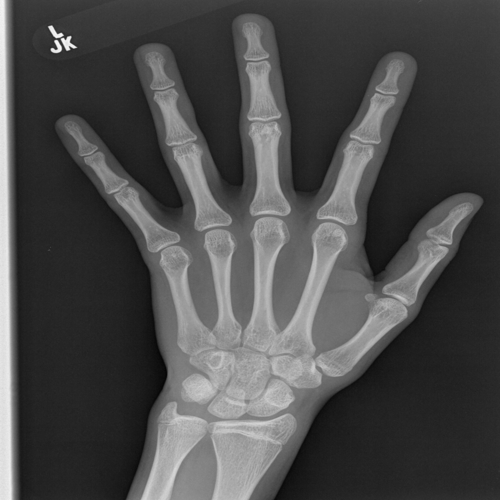

In [5]:
train_imgs_path = os.path.join('Resized_Bone_Age_Training_Set_500_500', 'Resized_Training_Set_Images')
valid_imgs_path = os.path.join('Resized_Bone_Age_Validation_Set_500_500', 'Resized_Validation_Set_Images')
test_imgs_path = os.path.join('Resized_Bone_Age_Test_Set_500_500', 'Resized_Test_Set_Images')
#train_imgs_path = os.path.join('Resized_Bone_Age_Training_Set_240_240', 'Resized_Training_Set_Images')
#valid_imgs_path = os.path.join('Resized_Bone_Age_Validation_Set_240_240', 'Resized_Validation_Set_Images')
#test_imgs_path = os.path.join('Resized_Bone_Age_Test_Set_240_240', 'Resized_Test_Set_Images')

# Example
ex_img_path = os.path.join(train_imgs_path, '1377.png')
ex_img = Image.open(ex_img_path)
print(type(ex_img))
#print(ex_img.size)
img_array = np.array(ex_img)
print(img_array.shape)

ex_img

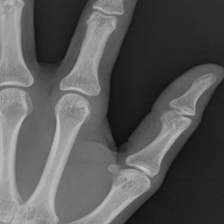

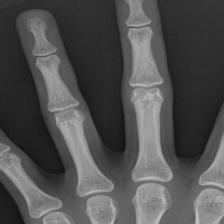

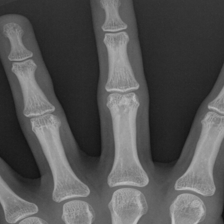

In [6]:
patches = extract_patches_2d(img_array, patch_size = patch_size, max_patches = max_patches, random_state = 12345)

for ima in patches:
    display(Image.fromarray(ima))

## Preprocessing

### Training Set

In [7]:
# Read the CSV file into a DataFrame
train_df = pd.read_csv('/content/drive/MyDrive/Ground_Truth_Training.csv')

# Dataframe manipulation
train_df['path'] = train_df['id'].astype(str).map(lambda x: os.path.join(train_imgs_path, '{}.png'.format(x)))
train_df['exists'] = train_df['path'].map(os.path.exists)
print(train_df['exists'].sum(), 'images found of', train_df.shape[0], 'total\n')
train_boneage_mean = train_df['boneage'].mean()
train_boneage_std = train_df['boneage'].std()
train_df['normalized_boneage'] = train_df['boneage'].map(lambda x: (x - train_boneage_mean) / train_boneage_std)
#age_df.dropna(inplace = True)
train_df['male'] = train_df['male'].astype(int) #converrts true or false into 1 and 0
train_df.sort_values('id')

# Useful info
print(train_df.head())
print('\nData shape: ', train_df.shape)
print("\nMax training boneage:", train_df['boneage'].max())
print("Min training boneage:", train_df['boneage'].min())
print("\nMean training boneage:", train_boneage_mean)
print("Standard deviation training boneage:", train_boneage_std, "\n\n")

12611 images found of 12611 total

     id  boneage  male                                               path  \
0  1377      180     0  Resized_Bone_Age_Training_Set_500_500/Resized_...   
1  1378       12     0  Resized_Bone_Age_Training_Set_500_500/Resized_...   
2  1379       94     0  Resized_Bone_Age_Training_Set_500_500/Resized_...   
3  1380      120     1  Resized_Bone_Age_Training_Set_500_500/Resized_...   
4  1381       82     0  Resized_Bone_Age_Training_Set_500_500/Resized_...   

   exists  normalized_boneage  
0    True            1.279181  
1    True           -2.800269  
2    True           -0.809109  
3    True           -0.177766  
4    True           -1.100498  

Data shape:  (12611, 6)

Max training boneage: 228
Min training boneage: 1

Mean training boneage: 127.3207517246848
Standard deviation training boneage: 41.182021399396326 




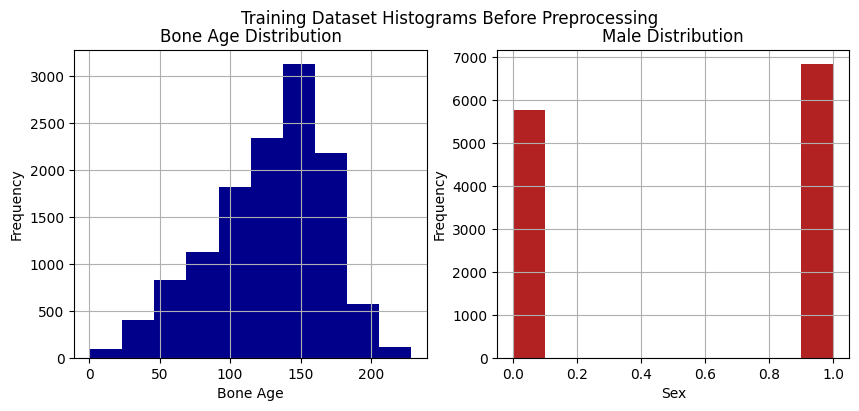

In [8]:
# Histograms of data distributions before preprocessing
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 4))
fig.suptitle('Training Dataset Histograms Before Preprocessing')
ax1.hist(train_df['boneage'], color = 'darkblue')
ax2.hist(train_df['male'], color = 'firebrick')
ax1.set_title('Bone Age Distribution')
ax1.set_xlabel('Bone Age')
ax1.set_ylabel('Frequency')
ax2.set_title('Male Distribution')
ax2.set_xlabel('Sex')
ax2.set_ylabel('Frequency')
ax1.grid()
ax2.grid()

#plt.savefig('/content/drive/MyDrive/Histo_Before_Preprocessing_Training.pdf', bbox_inches = 'tight')

In [9]:
# Data re-distribution
train_df['boneage_category'] = pd.cut(train_df['boneage'], 10)
train_df = train_df.groupby(['boneage_category', 'male']).apply(lambda x: x.sample(500, replace = True)).reset_index(drop=True)
train_boneage_mean = train_df['boneage'].mean()
train_boneage_std = train_df['boneage'].std()
train_df['normalized_boneage'] = train_df['boneage'].map(lambda x: (x - train_boneage_mean) / train_boneage_std)

# Useful info
print(train_df.head())
print('\nData shape: ', train_df.shape)
print("\nMax training boneage:", train_df['boneage'].max())
print("Min training boneage:", train_df['boneage'].min())
print("\nMean training boneage:", train_boneage_mean)
print("Standard deviation training boneage:", train_boneage_std, "\n\n")

      id  boneage  male                                               path  \
0  12023        6     0  Resized_Bone_Age_Training_Set_500_500/Resized_...   
1   9584       18     0  Resized_Bone_Age_Training_Set_500_500/Resized_...   
2   9584       18     0  Resized_Bone_Age_Training_Set_500_500/Resized_...   
3  10758       15     0  Resized_Bone_Age_Training_Set_500_500/Resized_...   
4   3823       18     0  Resized_Bone_Age_Training_Set_500_500/Resized_...   

   exists  normalized_boneage boneage_category  
0    True           -1.672212    (0.773, 23.7]  
1    True           -1.487483    (0.773, 23.7]  
2    True           -1.487483    (0.773, 23.7]  
3    True           -1.533665    (0.773, 23.7]  
4    True           -1.487483    (0.773, 23.7]  

Data shape:  (10000, 7)

Max training boneage: 228
Min training boneage: 1

Mean training boneage: 114.6267
Standard deviation training boneage: 64.95988859151917 




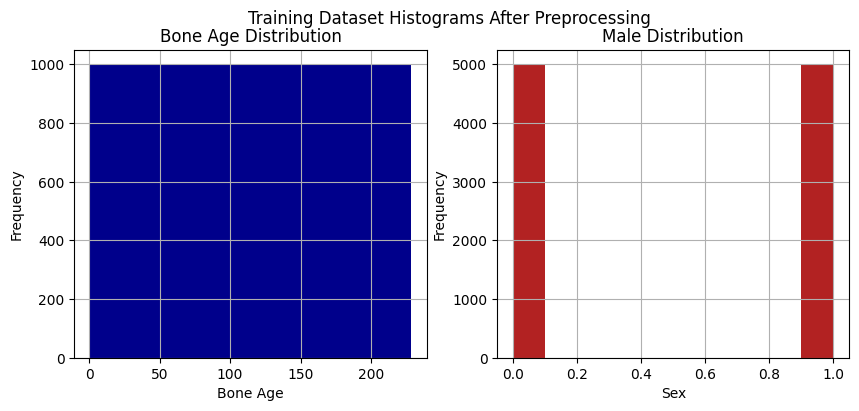

In [10]:
# Histograms of data distributions after preprocessing
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 4))
fig.suptitle('Training Dataset Histograms After Preprocessing')
ax1.hist(train_df['boneage'], color = 'darkblue')
ax2.hist(train_df['male'], color = 'firebrick')
ax1.set_title('Bone Age Distribution')
ax1.set_xlabel('Bone Age')
ax1.set_ylabel('Frequency')
ax2.set_title('Male Distribution')
ax2.set_xlabel('Sex')
ax2.set_ylabel('Frequency')
ax1.grid()
ax2.grid()

#plt.savefig('/content/drive/MyDrive/Histo_After_Preprocessing_Training.pdf', bbox_inches = 'tight')

### Validation Set

In [13]:
# Read the CSV file into a DataFrame
valid_df = pd.read_csv('/content/drive/MyDrive/Ground_Truth_Validation.csv')

# Dataframe manipulation
new_column_names = {'Image ID': 'id', 'Bone Age (months)': 'boneage'}
valid_df.rename(columns=new_column_names, inplace=True)
valid_df['path'] = valid_df['id'].astype(str).map(lambda x: os.path.join(valid_imgs_path, '{}.png'.format(x)))
valid_df['exists'] = valid_df['path'].map(os.path.exists)
print(valid_df['exists'].sum(), 'images found of', valid_df.shape[0], 'total\n')
valid_boneage_mean = valid_df['boneage'].mean()
valid_boneage_std = valid_df['boneage'].std()
valid_df['normalized_boneage'] = valid_df['boneage'].map(lambda x: (x - valid_boneage_mean) / valid_boneage_std)
#valid_df['male'] = valid_df['male'].map({"VERO": 1, "FALSO": 0})
valid_df['male'] = valid_df['male'].astype(int) #converrts true or false into 1 and 0
valid_df.sort_values('id')

# Useful info
print(valid_df.head())
print('\nData shape: ', valid_df.shape)
print("\n\nMax validation boneage:", valid_df['boneage'].max())
print("Min validation boneage:", valid_df['boneage'].min())
print("\nMean validation boneage:", valid_boneage_mean)
print("Standard deviation validation boneage:", valid_boneage_std, "\n\n")

1425 images found of 1425 total

     id  male  boneage                                               path  \
0  1386     0       30  Resized_Bone_Age_Validation_Set_500_500/Resize...   
1  1392     1      162  Resized_Bone_Age_Validation_Set_500_500/Resize...   
2  1397     0       18  Resized_Bone_Age_Validation_Set_500_500/Resize...   
3  1401     0      132  Resized_Bone_Age_Validation_Set_500_500/Resize...   
4  1410     1       57  Resized_Bone_Age_Validation_Set_500_500/Resize...   

   exists  normalized_boneage  
0    True           -2.328663  
1    True            0.835135  
2    True           -2.616281  
3    True            0.116090  
4    True           -1.681522  

Data shape:  (1425, 6)


Max validation boneage: 228
Min validation boneage: 3

Mean validation boneage: 127.15649122807018
Standard deviation validation boneage: 41.72201092403196 




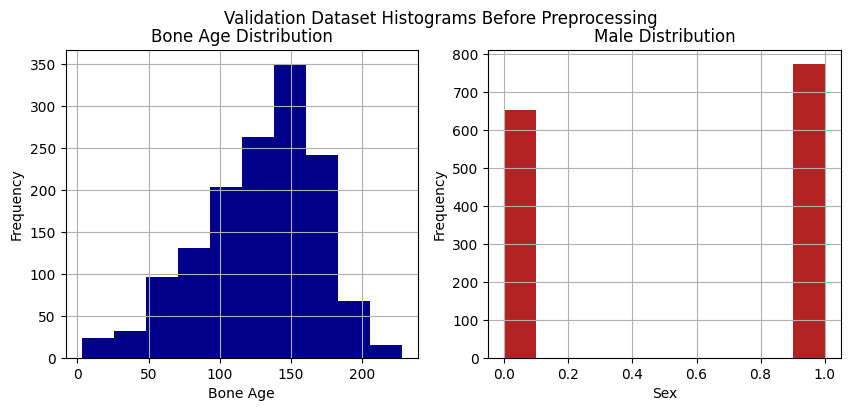

In [14]:
# Histograms of data distributions before preprocessing
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 4))
fig.suptitle('Validation Dataset Histograms Before Preprocessing')
ax1.hist(valid_df['boneage'], color = 'darkblue')
ax2.hist(valid_df['male'], color = 'firebrick')
ax1.set_title('Bone Age Distribution')
ax1.set_xlabel('Bone Age')
ax1.set_ylabel('Frequency')
ax2.set_title('Male Distribution')
ax2.set_xlabel('Sex')
ax2.set_ylabel('Frequency')
ax1.grid()
ax2.grid()

#plt.savefig('/content/drive/MyDrive/Histo_Before_Preprocessing_Validation.pdf', bbox_inches = 'tight')

In [15]:
# Data re-distribution
valid_df['boneage_category'] = pd.cut(valid_df['boneage'], 10)
valid_df = train_df.groupby(['boneage_category', 'male']).apply(lambda x: x.sample(50, replace = True)).reset_index(drop=True)
valid_boneage_mean = valid_df['boneage'].mean()
valid_boneage_std = valid_df['boneage'].std()
valid_df['normalized_boneage'] = valid_df['boneage'].map(lambda x: (x - valid_boneage_mean) / valid_boneage_std)


# Useful info
print(valid_df.head())
print('\nData shape: ', valid_df.shape)
print("\n\nMax validation boneage:", valid_df['boneage'].max())
print("Min validation boneage:", valid_df['boneage'].min())
print("\nMean validation boneage:", valid_boneage_mean)
print("Standard deviation validation boneage:", valid_boneage_std, "\n\n")

      id  boneage  male                                               path  \
0  12023        6     0  Resized_Bone_Age_Training_Set_500_500/Resized_...   
1  12023        6     0  Resized_Bone_Age_Training_Set_500_500/Resized_...   
2   1559       21     0  Resized_Bone_Age_Training_Set_500_500/Resized_...   
3   3079       16     0  Resized_Bone_Age_Training_Set_500_500/Resized_...   
4   8706       21     0  Resized_Bone_Age_Training_Set_500_500/Resized_...   

   exists  normalized_boneage boneage_category  
0    True           -1.669729    (0.773, 23.7]  
1    True           -1.669729    (0.773, 23.7]  
2    True           -1.438597    (0.773, 23.7]  
3    True           -1.515641    (0.773, 23.7]  
4    True           -1.438597    (0.773, 23.7]  

Data shape:  (1000, 7)


Max validation boneage: 228
Min validation boneage: 1

Mean validation boneage: 114.362
Standard deviation validation boneage: 64.89797148372746 




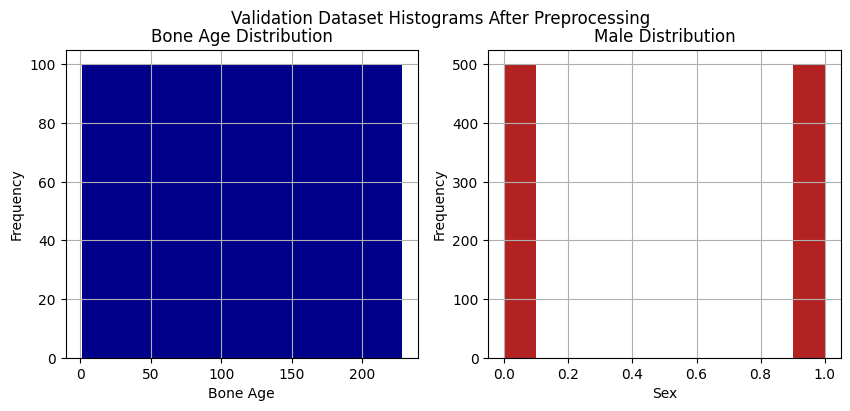

In [16]:
# Histograms of data distributions after preprocessing
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 4))
fig.suptitle('Validation Dataset Histograms After Preprocessing')
ax1.hist(valid_df['boneage'], color = 'darkblue')
ax2.hist(valid_df['male'], color = 'firebrick')
ax1.set_title('Bone Age Distribution')
ax1.set_xlabel('Bone Age')
ax1.set_ylabel('Frequency')
ax2.set_title('Male Distribution')
ax2.set_xlabel('Sex')
ax2.set_ylabel('Frequency')
ax1.grid()
ax2.grid()

#plt.savefig('/content/drive/MyDrive/Histo_After_Preprocessing_Validation.pdf', bbox_inches = 'tight')

### Test Set

In [17]:
# Read the CSV file into a DataFrame
test_df = pd.read_excel('/content/drive/MyDrive/Ground_Truth_Test.xlsx' )

# Dataframe manipulation
new_column_names = {'Case ID': 'id', 'Ground truth bone age (months)': 'boneage', 'Sex': 'male'}
test_df.rename(columns=new_column_names, inplace=True)
test_df['path'] = test_df['id'].astype(str).map(lambda x: os.path.join(test_imgs_path, '{}.png'.format(x)))
test_df['exists'] = test_df['path'].map(os.path.exists)
print(valid_df['exists'].sum(), 'images found of', valid_df.shape[0], 'total\n')
test_boneage_mean = test_df['boneage'].mean()
test_boneage_std = test_df['boneage'].std()
test_df['normalized_boneage'] = test_df['boneage'].map(lambda x: (x - test_boneage_mean) / test_boneage_std)
test_df['male'] = test_df['male'].map({"M": 1, "F": 0})
#valid_df['male'] = valid_df['male'].astype(int) #converrts true or false into 1 and 0
test_df.sort_values('id')

# Useful info
print(test_df.head())
print('\nData shape: ', test_df.shape)
print("\n\nMax test boneage:", test_df['boneage'].max())
print("Min test boneage:", test_df['boneage'].min())
print("\nMean test boneage:", test_boneage_mean)
print("Standard deviation test boneage:", test_boneage_std, "\n\n")

1000 images found of 1000 total

     id  male     boneage                                               path  \
0  4360     1  168.934249  Resized_Bone_Age_Test_Set_500_500/Resized_Test...   
1  4361     1  169.652678  Resized_Bone_Age_Test_Set_500_500/Resized_Test...   
2  4362     1   73.256112  Resized_Bone_Age_Test_Set_500_500/Resized_Test...   
3  4363     1  152.862669  Resized_Bone_Age_Test_Set_500_500/Resized_Test...   
4  4364     1  135.456954  Resized_Bone_Age_Test_Set_500_500/Resized_Test...   

   exists  normalized_boneage  
0    True            0.854218  
1    True            0.870877  
2    True           -1.364379  
3    True            0.481548  
4    True            0.077942  

Data shape:  (200, 6)


Max test boneage: 219.05790068732688
Min test boneage: 11.213674589225533

Mean test boneage: 132.09566444786344
Standard deviation test boneage: 43.1255298885517 




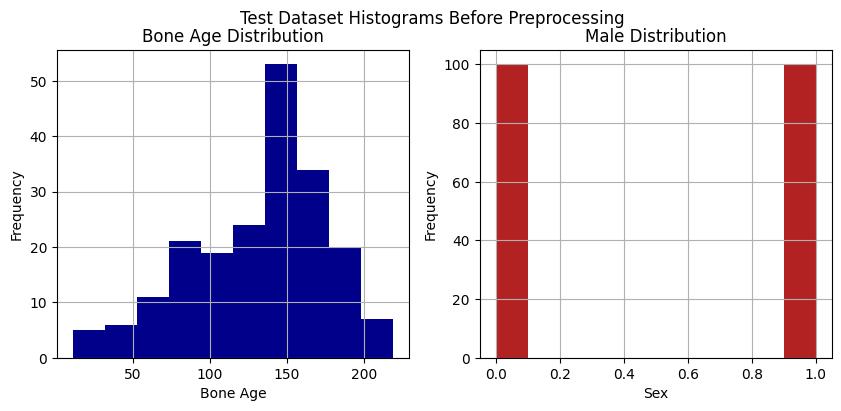

In [18]:
# Histograms of data distributions before preprocessing
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 4))
fig.suptitle('Test Dataset Histograms Before Preprocessing')
ax1.hist(test_df['boneage'], color = 'darkblue')
ax2.hist(test_df['male'], color = 'firebrick')
ax1.set_title('Bone Age Distribution')
ax1.set_xlabel('Bone Age')
ax1.set_ylabel('Frequency')
ax2.set_title('Male Distribution')
ax2.set_xlabel('Sex')
ax2.set_ylabel('Frequency')
ax1.grid()
ax2.grid()

#plt.savefig('/content/drive/MyDrive/Histo_Before_Preprocessing_Test.pdf', bbox_inches = 'tight')

In [19]:
# Data re-distribution
test_df['boneage_category'] = pd.cut(test_df['boneage'], 10)
test_df = test_df.groupby(['boneage_category', 'male']).apply(lambda x: x.sample(8, replace = True)).reset_index(drop=True)
test_boneage_mean = test_df['boneage'].mean()
test_boneage_std = test_df['boneage'].std()
test_df['normalized_boneage'] = test_df['boneage'].map(lambda x: (x - test_boneage_mean) / test_boneage_std)

# Useful info
print(test_df.head())
print('\nData shape: ', test_df.shape)
print("\n\nMax test boneage:", test_df['boneage'].max())
print("Min test boneage:", test_df['boneage'].min())
print("\nMean test boneage:", test_boneage_mean)
print("Standard deviation test boneage:", test_boneage_std, "\n\n")

     id  male    boneage                                               path  \
0  4510     0  30.173793  Resized_Bone_Age_Test_Set_500_500/Resized_Test...   
1  4539     0  19.845332  Resized_Bone_Age_Test_Set_500_500/Resized_Test...   
2  4539     0  19.845332  Resized_Bone_Age_Test_Set_500_500/Resized_Test...   
3  4483     0  17.974916  Resized_Bone_Age_Test_Set_500_500/Resized_Test...   
4  4539     0  19.845332  Resized_Bone_Age_Test_Set_500_500/Resized_Test...   

   exists  normalized_boneage  boneage_category  
0    True           -1.436095  (11.006, 31.998]  
1    True           -1.611001  (11.006, 31.998]  
2    True           -1.611001  (11.006, 31.998]  
3    True           -1.642675  (11.006, 31.998]  
4    True           -1.611001  (11.006, 31.998]  

Data shape:  (160, 7)


Max test boneage: 219.05790068732688
Min test boneage: 11.213674589225533

Mean test boneage: 114.97719716540887
Standard deviation test boneage: 59.05140465068729 




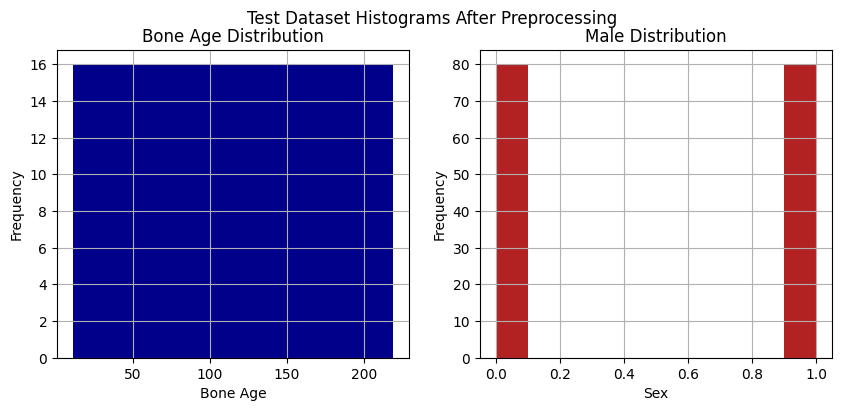

In [20]:
# Histograms of data distributions after preprocessing
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 4))
fig.suptitle('Test Dataset Histograms After Preprocessing')
ax1.hist(test_df['boneage'], color = 'darkblue')
ax2.hist(test_df['male'], color = 'firebrick')
ax1.set_title('Bone Age Distribution')
ax1.set_xlabel('Bone Age')
ax1.set_ylabel('Frequency')
ax2.set_title('Male Distribution')
ax2.set_xlabel('Sex')
ax2.set_ylabel('Frequency')
ax1.grid()
ax2.grid()

#plt.savefig('/content/drive/MyDrive/Histo_After_Preprocessing_Test.pdf', bbox_inches = 'tight')

## Dataloader Preparation

In [23]:
if analyze_patch:
    train_generator = CustomImgPatchGen(train_df, batch_size, patch_size, max_patches, patch_augmentation_params)
    val_generator = CustomImgPatchGen(valid_df, batch_size, patch_size, max_patches, patch_augmentation_params)
    test_generator = CustomImgPatchGen(test_df, batch_size, patch_size, max_patches, patch_augmentation_params)
else:
    train_generator = CustomImgGen(train_df, batch_size, img_augmentation_params)
    val_generator = CustomImgGen(valid_df, batch_size, img_augmentation_params)
    test_generator = CustomImgGen(test_df, batch_size, img_augmentation_params)

## Useful Functions

In [24]:
#Mae months metric
def mae_months(in_gt, in_pred):
    return mean_absolute_error(valid_boneage_mean+valid_boneage_std*in_gt, valid_boneage_mean+valid_boneage_std*in_pred)

class LossLogger(Callback):
    def __init__(self):
        super().__init__()
        self.batch_loss_history = []      # Training loss
        self.val_loss_history = []        # Validation loss
        self.batch_mae_history = []    # Training mae
        self.val_mae_history = []      # Validation mae

    def on_batch_end(self, batch, logs=None):
        self.batch_loss_history.append(logs['loss'])
        self.batch_mae_history.append(logs['mae_months'])
    def on_epoch_end(self, epoch, logs=None):
        self.val_loss_history.append(logs['val_loss'])
        self.val_mae_history.append(logs['val_mae_months'])

## Model's Training Or Loading Weights of a Pre-Trained Model


In [ ]:
if model_selector == 'inception':
    model = inception_model(image_size, batch_size)
elif model_selector == 'xception':
    model = xception_model(image_size, batch_size)
elif model_selector == 'attention':
    model = attention_model(image_size, batch_size)
elif model_selector == 'resnet':
    model = resnet_model(patch_size, batch_size)
else:
    print('Error: model not in list.')

94765736/94765736 [==============================] - 5s 0us/step


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Images (InputLayer)         [(8, 224, 224, 3)]           0         []                            
                                                                                                  
 resnet50 (Functional)       (None, None, None, 2048)     2358771   ['Images[0][0]']              
                                                          2                                       
                                                                                                  
 global_average_pooling2d (  (8, 2048)                    0         ['resnet50[0][0]']            
 GlobalAveragePooling2D)                                                                          
                                                                                              

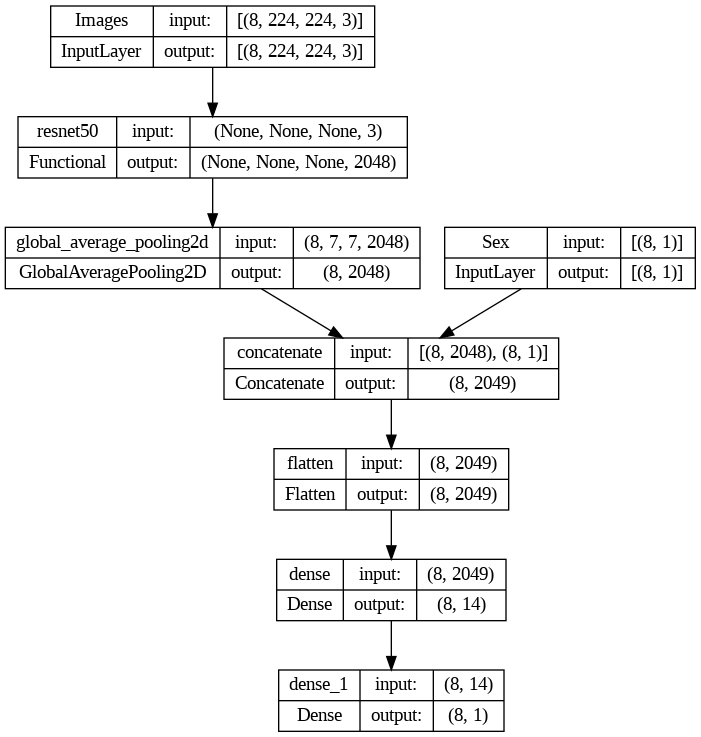

In [ ]:
plot_model(model, model_selector+"_model_plot.png", show_shapes=True)

In [ ]:
if train:
    #initial_learning_rate = 0.001
    #lr_schedule = ExponentialDecay(initial_learning_rate, decay_steps=200, decay_rate=0.7, staircase=True)
    #lr_schedule = PolynomialDecay(0.001, decay_steps=625, end_learning_rate = 0.00001, power=4)
    model.compile(optimizer = 'adam', loss = 'mse', metrics = [mae_months])
    weight_path="bone_age_{model}_weights_best.hdf5".format(model = model_selector)
    checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min', save_weights_only = True)
    reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10, verbose=1, mode='auto', min_delta=0.0001, cooldown=5, min_lr=0.0001)
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience= 5, verbose=0, mode='auto')

    # Create an instance of the LossLogger callback
    loss_logger = LossLogger()
    callbacks_list = [checkpoint, reduceLROnPlat, early_stopping, loss_logger]

    model.fit(train_generator,
          steps_per_epoch=len(train_df) // batch_size,
          validation_data = val_generator,
          epochs = n_epochs,
          validation_steps=len(valid_df) // batch_size,
          callbacks = callbacks_list)
else:
    model.load_weights('/content/drive/MyDrive/bone_age_{model}_weights_best.hdf5'.format(model = model_selector))

Epoch 1/7
1250/1250 [==============================] - ETA: 0s - loss: 0.1828 - mae_months: 20.9619
Epoch 1: val_loss improved from inf to 0.09975, saving model to bone_age_resnet_weights_best.hdf5
1250/1250 [==============================] - 481s 374ms/step - loss: 0.1828 - mae_months: 20.9619 - val_loss: 0.0997 - val_mae_months: 15.9592 - lr: 0.0010
Epoch 2/7
1250/1250 [==============================] - ETA: 0s - loss: 0.0985 - mae_months: 15.7682
Epoch 2: val_loss improved from 0.09975 to 0.09287, saving model to bone_age_resnet_weights_best.hdf5
1250/1250 [==============================] - 462s 369ms/step - loss: 0.0985 - mae_months: 15.7682 - val_loss: 0.0929 - val_mae_months: 15.1717 - lr: 0.0010
Epoch 3/7
1250/1250 [==============================] - ETA: 0s - loss: 0.0832 - mae_months: 14.5269
Epoch 3: val_loss improved from 0.09287 to 0.07452, saving model to bone_age_resnet_weights_best.hdf5
1250/1250 [==============================] - 460s 368ms/step - loss: 0.0832 - mae_mont

In [ ]:
np.save("bone_age_{model}_batch_loss".format(model = model_selector), loss_logger.batch_loss_history)
np.save("bone_age_{model}_val_loss".format(model = model_selector), loss_logger.val_loss_history)
np.save("bone_age_{model}_batch_mae".format(model = model_selector), loss_logger.batch_mae_history)
np.save("bone_age_{model}_val_mae".format(model = model_selector), loss_logger.val_mae_history)

### Training Plots

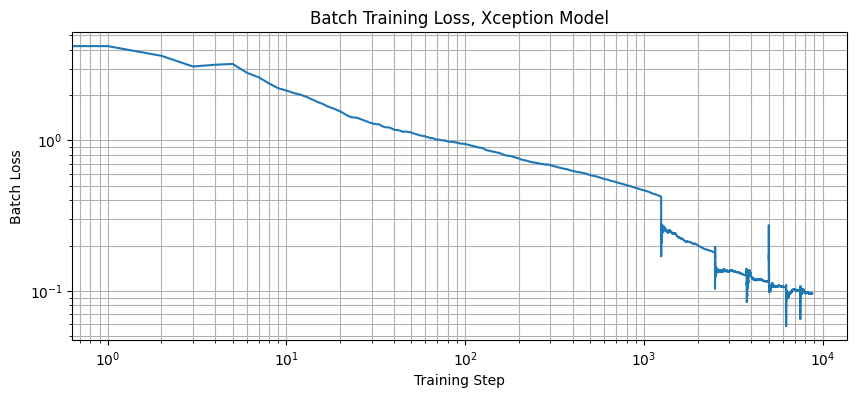

In [ ]:
# LogLog plot of training batch loss
fig = plt.figure(figsize = (10, 4))
plt.plot(np.arange(len(loss_logger.batch_loss_history)), loss_logger.batch_loss_history)
plt.loglog()
plt.title('Batch Training Loss, Xception Model')
plt.xlabel('Training Step')
plt.ylabel('Batch Loss')
plt.grid(True, which="both")

#plt.savefig("bone_age_{model}_batch_loss_plot.pdf".format(model = model_selector), bbox_inches = 'tight')

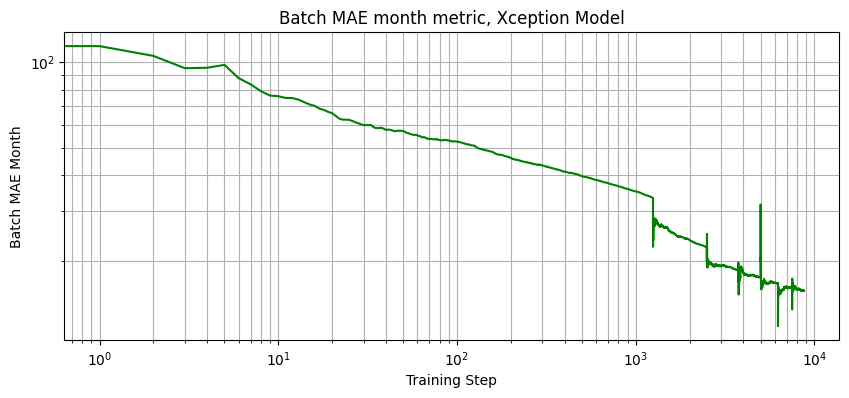

In [ ]:
# LogLog plot of training batch mae month
fig = plt.figure(figsize = (10, 4))
plt.plot(np.arange(len(loss_logger.batch_mae_history)), loss_logger.batch_mae_history, color = 'green')
plt.loglog()
plt.title('Batch MAE month metric, Xception Model')
plt.xlabel('Training Step')
plt.ylabel('Batch MAE Month')
plt.grid(True, which="both")

#plt.savefig("bone_age_{model}_batch_mae_plot.pdf".format(model = model_selector), bbox_inches = 'tight')

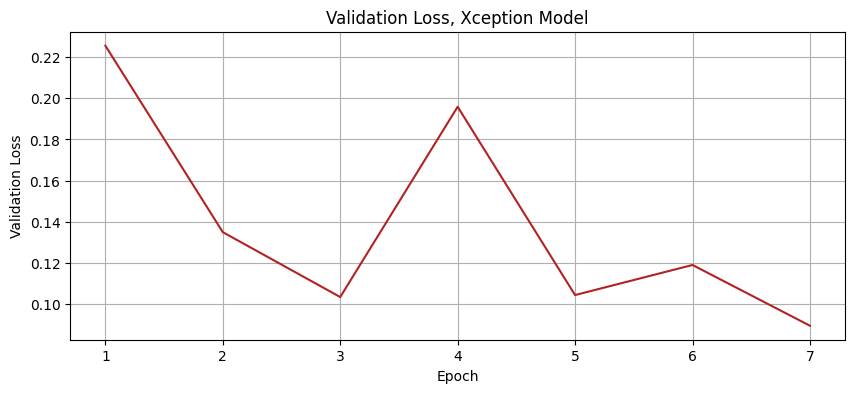

In [ ]:
# Plot of val loss for each epoch
fig = plt.figure(figsize = (10, 4))
plt.plot(np.arange(len(loss_logger.val_loss_history))+1, loss_logger.val_loss_history, color = 'firebrick')
#plt.loglog()
plt.title('Validation Loss, Xception Model')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.grid(True, which="both")

#plt.savefig("bone_age_{model}_val_loss_plot.pdf".format(model = model_selector), bbox_inches = 'tight')

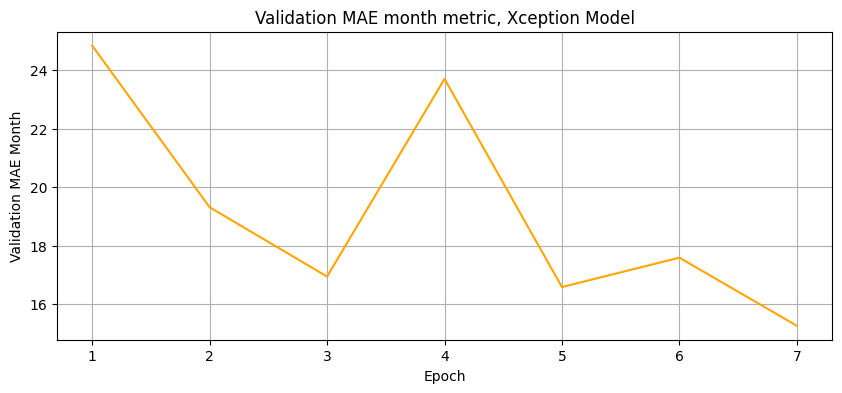

In [ ]:
# Plot of val mae for each epoch
fig = plt.figure(figsize = (10, 4))
plt.plot(np.arange(len(loss_logger.val_mae_history))+1, loss_logger.val_mae_history, color = 'orange')
#plt.loglog()
plt.title('Validation MAE month metric, Xception Model')
plt.xlabel('Epoch')
plt.ylabel('Validation MAE Month')
plt.grid(True, which="both")

#plt.savefig("bone_age_{model}_val_mae_plot.pdf".format(model = model_selector), bbox_inches = 'tight')

## Fine tuning on patch size and patch number

In [ ]:
#size = 224

In [29]:
patches = [3, 9, 36, 150]
sizes = [224, 128, 64, 32]
registered_histories=[]

for patch, size in zip(patches, sizes):
    batch_loss_history = []
    train_generator = CustomImgPatchGen(train_df, batch_size, (size, size) , patch, patch_augmentation_params)
    val_generator = CustomImgPatchGen(valid_df, batch_size, (size, size), patch, patch_augmentation_params)

    model_resnet50 = resnet_model((size, size), batch_size)
    model_resnet50.compile(optimizer= 'adam', loss ='mse', metrics = [mae_months])

    reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10, verbose=1, mode='auto', min_delta=0.0001, cooldown=5, min_lr=0.0001)
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience= 5, verbose=0, mode='auto')
    loss_logger = LossLogger()
    callbacks_list = [reduceLROnPlat, early_stopping, loss_logger]

    history = model_resnet50.fit(train_generator,
        steps_per_epoch=len(train_df) // batch_size,
        validation_data = val_generator,
        epochs = 1,
        validation_steps=len(valid_df) // batch_size,
        callbacks = callbacks_list)

    registered_histories.append(loss_logger.batch_loss_history)

1250/1250 [==============================] - 1000s 794ms/step - loss: 0.8542 - mae_months: 50.5909 - val_loss: 0.8472 - val_mae_months: 50.1744 - lr: 0.0010


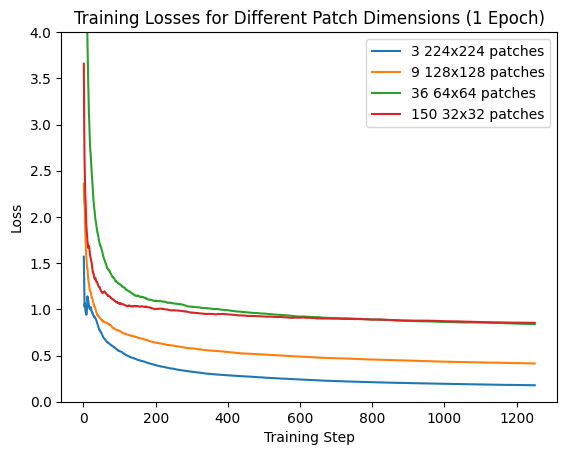

In [32]:
# Plot the loss values at the end of each batch
plt.figure()
plt.plot(np.arange(len(registered_histories[0]))+1, registered_histories[0], label='3 224x224 patches')
plt.plot(np.arange(len(registered_histories[1]))+1, registered_histories[1], label='9 128x128 patches')
plt.plot(np.arange(len(registered_histories[2]))+1, registered_histories[2], label='36 64x64 patches')
plt.plot(np.arange(len(registered_histories[3]))+1, registered_histories[3], label='150 32x32 patches')
plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.ylim(0, 4)
plt.title('Training Losses for Different Patch Dimensions (1 Epoch)')
plt.legend()
plt.show()

## Models' comparison over test set

### Resnet

In [34]:
resnet = resnet_model(patch_size, batch_size)
resnet.load_weights('/content/drive/MyDrive/bone_age_resnet_weights_best.hdf5')

In [36]:
test_generator = CustomImgPatchGen(test_df, batch_size, patch_size, max_patches, patch_augmentation_params)

all_predicted_labels = []
all_associated_labels = []

# Iterate through batches
for batch_data, batch_labels in test_generator:
    # Make predictions on the batch data
    batch_predictions = resnet.predict(batch_data)

    # Append batch predictions and associated labels to the lists
    all_predicted_labels.extend(batch_predictions)
    all_associated_labels.extend(batch_labels)

1/1 [==============================] - 0s 25ms/step


In [37]:
ass_labels = np.array(all_associated_labels)
pred_labels = np.array(all_predicted_labels).flatten()
mse = np.mean(np.square(ass_labels - pred_labels))
print("MSE before the average (on each patch):", mse)

MSE before the average (on each patch): 0.09394105991244864


In [38]:
# Reshape the original array into a 2D array with 3 columns
pred_labels = (pred_labels).reshape(-1, 3)
ass_labels = (ass_labels).reshape(-1, 3)
# Calculate the mean along axis 1 (across columns)
pred_labels = np.mean(pred_labels, axis=1)
ass_labels = np.mean(ass_labels, axis=1)
mse = np.mean(np.square(ass_labels - pred_labels))
rmse = np.sqrt(np.mean((ass_labels - pred_labels) ** 2))
P = np.corrcoef(ass_labels, pred_labels)[0, 1]
print("ResNet model\n\nMSE:", mse, "\nRMSE:", rmse, "\nCorrelation coefficient:", P)

ResNet model

MSE: 0.06619873035413715 
RMSE: 0.2572911392841525 
Correlation coefficient: 0.9684918555880954


### Inception

In [40]:
inception = inception_model(image_size, batch_size)
inception.load_weights('/content/drive/MyDrive/bone_age_inception_weights_best.hdf5')

In [41]:
test_generator = CustomImgGen(test_df, batch_size, img_augmentation_params)

Inc_predicted_labels = []
Inc_associated_labels = []

# Iterate through batches
for batch_data, batch_labels in test_generator:
    # Make predictions on the batch data
    batch_predictions = inception.predict(batch_data)

    # Append batch predictions and associated labels to the lists
    Inc_predicted_labels.extend(batch_predictions)
    Inc_associated_labels.extend(batch_labels)

1/1 [==============================] - 0s 39ms/step


In [42]:
Inc_ass_labels = np.array(Inc_associated_labels)
Inc_pred_labels = np.array(Inc_predicted_labels).flatten()
mse = np.mean(np.square(Inc_ass_labels - Inc_pred_labels))
rmse = np.sqrt(np.mean((Inc_ass_labels - Inc_pred_labels) ** 2))
P = np.corrcoef(Inc_ass_labels, Inc_pred_labels)[0, 1]
print("Inception model\n\nMSE :", mse, "\nRMSE:", rmse, "\ncorrelation coefficient:", P)

Inception model

MSE : 0.21324014084623982 
RMSE: 0.4617793205051952 
correlation coefficient: 0.8952416990149481


### Xception

In [43]:
xception = xception_model(image_size, batch_size)
xception.load_weights('/content/drive/MyDrive/bone_age_xception_weights_best.hdf5')

83683744/83683744 [==============================] - 5s 0us/step


In [44]:
test_generator = CustomImgGen(test_df, batch_size, img_augmentation_params)

Xce_predicted_labels = []
Xce_associated_labels = []

# Iterate through batches
for batch_data, batch_labels in test_generator:
    # Make predictions on the batch data
    batch_predictions = xception.predict(batch_data)

    # Append batch predictions and associated labels to the lists
    Xce_predicted_labels.extend(batch_predictions)
    Xce_associated_labels.extend(batch_labels)

1/1 [==============================] - 0s 61ms/step


In [45]:
Xce_ass_labels = np.array(Xce_associated_labels)
Xce_pred_labels = np.array(Xce_predicted_labels).flatten()
mse = np.mean(np.square(Xce_ass_labels - Xce_pred_labels))
rmse = np.sqrt(np.mean((Xce_ass_labels - Xce_pred_labels) ** 2))
P = np.corrcoef(Xce_ass_labels, Xce_pred_labels)[0, 1]
print("Xception model\n\nMSE:", mse, "\nRMSE:", rmse, "\nCorrelation coefficient:", P)

Xception model

MSE: 0.1707476639593182 
RMSE: 0.41321624358115233 
Correlation coefficient: 0.9240227086948732


## Ensamble voting for regression task:

A voting ensemble works by combining the predictions from multiple models. It can be used for classification or regression. In the case of regression, this involves calculating the average of the predictions from the models.
Since the patch model seems to perform better, it is reasonable to assign the major weight to it.

In [46]:
# Sort input labels in ascending order
labels_sort = sorted(ass_labels)
# Rearrange the predicted labels based on the sorted_indices
preds_sort_Inc = [Inc_pred_labels[i] for i in np.argsort(Inc_ass_labels)]
preds_sort_Xce = [Xce_pred_labels[i] for i in np.argsort(Xce_ass_labels)]
preds_sort =     [pred_labels[i] for i in np.argsort(ass_labels)]

In [47]:
weights = [0.5, 0.1, 0.1]
ensemble_preds = np.average([ preds_sort, preds_sort_Inc, preds_sort_Xce], axis=0, weights=weights)
mse = np.mean(np.square(labels_sort - ensemble_preds))
rmse = np.sqrt(np.mean((labels_sort - ensemble_preds) ** 2))
P = np.corrcoef(labels_sort, ensemble_preds)[0, 1]
print("Ensable voting\n\nMSE:", mse, "\nRSME: ", rmse, "\nP-value: ", P)

Ensable voting

MSE: 0.057698137148292285 
RSME:  0.24020436538142326 
P-value:  0.9774768733526205


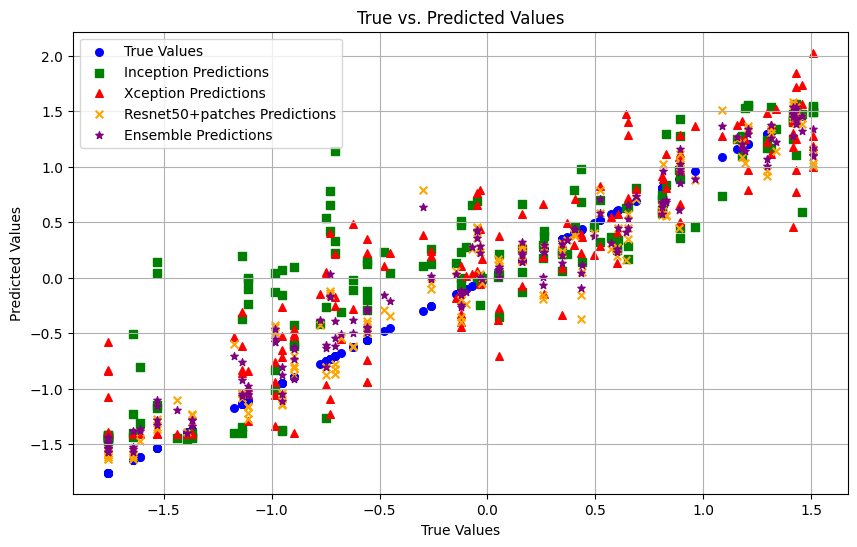

In [48]:
plt.figure(figsize=(10, 6))

plt.scatter(labels_sort, labels_sort, color='blue', label='True Values', marker='o', s=30)

# Model 1 predictions in green
plt.scatter(labels_sort, preds_sort_Inc, color='green', label='Inception Predictions', marker='s', s=30)

# Model 2 predictions in red
plt.scatter(labels_sort, preds_sort_Xce, color='red', label='Xception Predictions', marker='^', s=30)

# Model 3 predictions in orange
plt.scatter(labels_sort, preds_sort, color='orange', label='Resnet50+patches Predictions', marker='x', s=30)

# Ensemble predictions in purple
plt.scatter(labels_sort, ensemble_preds, color='purple', label='Ensemble Predictions', marker='*', s=30)

# Add labels and legend
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs. Predicted Values")
plt.legend(loc='best')

# Show the plot
plt.grid(True)
plt.show()